# 准备

In [2]:
import random
import torch
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
from timeit import default_timer
from scipy.io import loadmat
import yaml

sys.path.append("../")


from models import  FNN_train, compute_2dFourier_bases, compute_2dpca_bases, UnitGaussianNormalizer
from models.Galerkin import GkNN,myGkNN

torch.set_printoptions(precision=16)


torch.manual_seed(0)
np.random.seed(0)


###################################
# load configs
###################################
with open('my_config_2D.yml', 'r', encoding='utf-8') as f:
    config = yaml.full_load(f)

config = config["FFT_2D"]
config = dict(config)
config_data, config_model, config_train = (
    config["data"],
    config["model"],
    config["train"],
)
downsample_ratio = config_data["downsample_ratio"]
L = config_data["L"]
n_train = config_data["n_train"]
n_test = config_data["n_test"]
device = torch.device(config["train"]["device"])


###################################
# load data
###################################
data_path = "../data/darcy_2d/piececonst_r421_N1024_smooth1"
data = loadmat(data_path)

data_in = data["coeff"]  # shape: 1024,421,421
data_out = data["sol"]  # shape: 1024,421,421
print("data_in.shape:" , data_in.shape)
print("data_out.shape", data_out.shape)

Np_ref = data_in.shape[1]
grid_1d = np.linspace(0, L, Np_ref)
grid_x, grid_y = np.meshgrid(grid_1d, grid_1d)

data_in_ds = data_in[0:n_train, 0::downsample_ratio, 0::downsample_ratio]
grid_x_ds = grid_x[0::downsample_ratio, 0::downsample_ratio]
grid_y_ds = grid_y[0::downsample_ratio, 0::downsample_ratio]
data_out_ds = data_out[0:n_train, 0::downsample_ratio, 0::downsample_ratio]

# x_train, y_train are [n_data, n_x, n_channel] arrays
x_train = torch.from_numpy(
    np.stack(
        (
            data_in_ds,
            np.tile(grid_x_ds, (n_train, 1, 1)),
            np.tile(grid_y_ds, (n_train, 1, 1)),
        ),
        axis=-1,
    ).astype(np.float32)
)
y_train = torch.from_numpy(data_out_ds[:, :, :, np.newaxis].astype(np.float32))
# x_test, y_test are [n_data, n_x, n_channel] arrays
x_test = torch.from_numpy(
    np.stack(
        (
            data_in[-n_test:, 0::downsample_ratio, 0::downsample_ratio],
            np.tile(grid_x[0::downsample_ratio, 0::downsample_ratio], (n_test, 1, 1)),
            np.tile(grid_y[0::downsample_ratio, 0::downsample_ratio], (n_test, 1, 1)),
        ),
        axis=-1,
    ).astype(np.float32)
)
y_test = torch.from_numpy(
    data_out[-n_test:, 0::downsample_ratio, 0::downsample_ratio, np.newaxis].astype(
        np.float32
    )
)

x_train = x_train.reshape(x_train.shape[0], -1, x_train.shape[-1])   # shape: 800,11236,3  (11236 = 106*106 , 106-1 = (421-1) /4)
x_test = x_test.reshape(x_test.shape[0], -1, x_test.shape[-1])
y_train = y_train.reshape(y_train.shape[0], -1, y_train.shape[-1])   # shape: 800,11236,1
y_test = y_test.reshape(y_test.shape[0], -1, y_test.shape[-1])
if config_model['add_ones']:
    ones_1 = torch.ones(x_train.shape[0],x_train.shape[1],1)
    ones_2 = torch.ones(x_test.shape[0],x_test.shape[1],1)
    x_train = torch.cat((x_train,ones_1),dim=-1)
    x_test = torch.cat((x_test,ones_2),dim=-1)
print("x_train.shape: ",x_train.shape)
print("y_train.shape: ",y_train.shape)

x_normalizer = UnitGaussianNormalizer(x_train, dim=[])
y_normalizer = UnitGaussianNormalizer(y_train, dim=[])
###################################
#compute fourier bases
###################################
k_max = max(config_model["GkNN_modes"])
Np = (Np_ref + downsample_ratio - 1) // downsample_ratio
gridx, gridy, fbases, weights = compute_2dFourier_bases(Np, Np, k_max, L, L)
fbases = fbases.reshape(-1, k_max)
weights = weights.reshape(-1)
wfbases = fbases * np.tile(weights, (k_max, 1)).T
bases_fourier = torch.from_numpy(fbases.astype(np.float32)).to(device)
wbases_fourier = torch.from_numpy(wfbases.astype(np.float32)).to(device)


####################################
#compute pca bases
####################################
k_max = max(config_model["GkNN_modes"])
Np = (Np_ref + downsample_ratio - 1) // downsample_ratio
pca_data = data_out_ds.reshape((data_out_ds.shape[0], -1))
if config_model["pca_include_input"]:
    pca_data = np.vstack(
        (pca_data, data_in_ds.reshape((data_in_ds.shape[0], -1)))
    )
if config_model["pca_include_grid"]:
    n_grid = 1
    pca_data = np.vstack((pca_data, np.tile(grid_x_ds, (n_grid, 1))))
    pca_data = np.vstack((pca_data, np.tile(grid_y_ds, (n_grid, 1))))
print("Start SVD with data shape: ", pca_data.shape)
bases_pca, wbases_pca = compute_2dpca_bases(Np , k_max , L,  pca_data)
bases_pca, wbases_pca = bases_pca.to(device), wbases_pca.to(device)

bases_list = [bases_fourier, wbases_fourier, bases_pca, wbases_pca]



data_in.shape: (1024, 421, 421)
data_out.shape (1024, 421, 421)
x_train.shape:  torch.Size([800, 961, 4])
y_train.shape:  torch.Size([800, 961, 1])
Start SVD with data shape:  (800, 961)


# PCA基图像

torch.Size([961, 33])


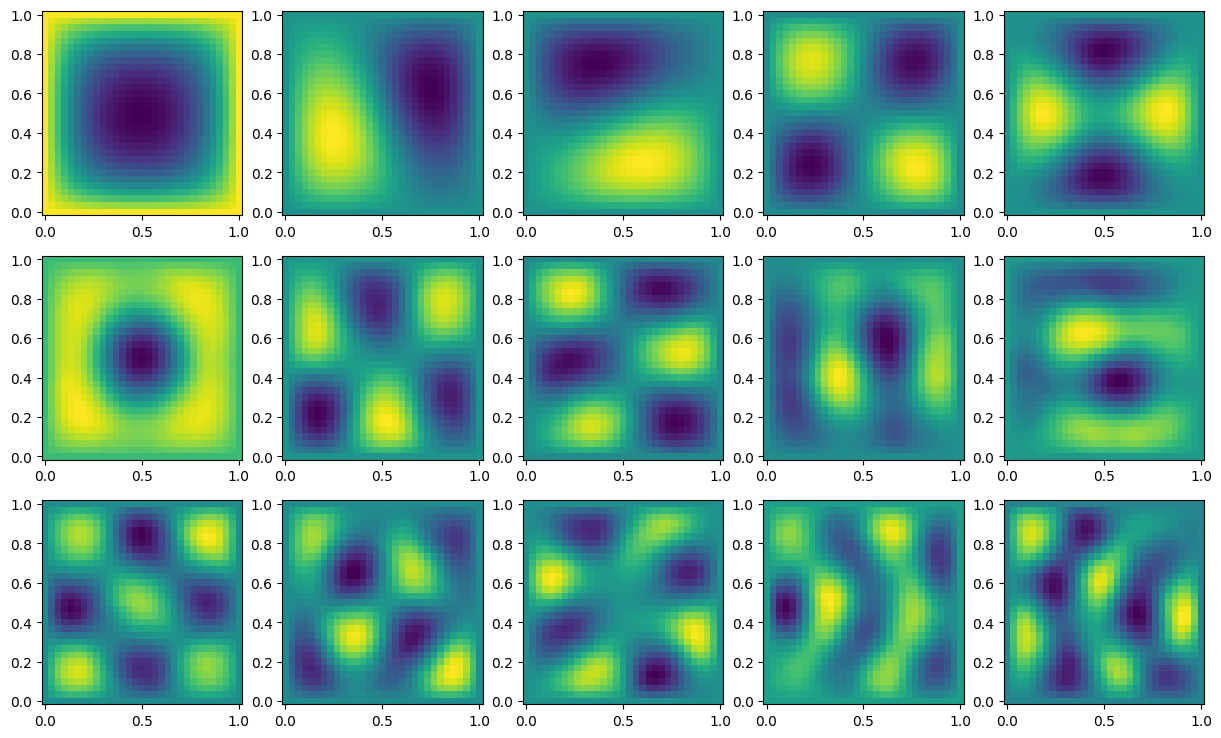

In [23]:
print(bases_pca.shape)
bases_pca_2d = bases_pca.reshape(Np,Np,k_max).to('cpu')
wbases_pca_2d = wbases_pca.reshape(Np,Np,k_max).to('cpu')
bases_fourier_2d = bases_fourier.reshape(Np,Np,k_max).to('cpu')
wbases_fourier_2d = wbases_fourier.reshape(Np,Np,k_max).to('cpu')
mygrid = np.linspace(0, L, Np)
grid_x, grid_y = np.meshgrid(mygrid, mygrid)
m=3
n=5
fig, axs = plt.subplots(m, n, figsize=(3*n,3*m))
for i in range(5):
    axs[0,i].pcolormesh(grid_x, grid_y, bases_pca_2d[:,:,i])
    axs[1,i].pcolormesh(grid_x, grid_y, bases_pca_2d[:,:,i+5])
    axs[2,i].pcolormesh(grid_x, grid_y, bases_pca_2d[:,:,i+10])
    # axs[2,i].pcolormesh(grid_x, grid_y, wbases_pca_2d[:,:,i])
    # axs[3,i].pcolormesh(grid_x, grid_y, bases_fourier_2d[:,:,i])
    # axs[4,i].pcolormesh(grid_x, grid_y, wbases_fourier_2d[:,:,i])

# axs[1].pcolormesh(grid_x, grid_y, data_out[0,:,:])

# 训练

In [2]:
###################################
#construct model and train
###################################
model = GkNN(bases_list,**config_model).to(device)


print("Start training ", "layer_type: ",config_model["layer_types"])
train_rel_l2_losses, test_rel_l2_losses, test_l2_losses = FNN_train(
    x_train, y_train, x_test, y_test, config, model, save_model_name=False
)

Start training  layer_type:  ['GalerkinConv_pca', 'GalerkinConv_pca', 'GalerkinConv_pca', 'GalerkinConv_pca']
Epoch :  0  Rel. Train L2 Loss :  0.19610210373997689  Rel. Test L2 Loss :  0.07902238368988038  Test L2 Loss :  0.000530128120444715
Epoch :  10  Rel. Train L2 Loss :  0.02676756450906396  Rel. Test L2 Loss :  0.02902290128171444  Test L2 Loss :  0.00019397055206354707
Epoch :  20  Rel. Train L2 Loss :  0.021341323293745516  Rel. Test L2 Loss :  0.024712661281228065  Test L2 Loss :  0.00016580719558987767
Epoch :  30  Rel. Train L2 Loss :  0.020972614977508783  Rel. Test L2 Loss :  0.02501622386276722  Test L2 Loss :  0.00016775954223703594
Epoch :  40  Rel. Train L2 Loss :  0.02216673521324992  Rel. Test L2 Loss :  0.03347630999982357  Test L2 Loss :  0.0002251421072287485
Epoch :  50  Rel. Train L2 Loss :  0.019964768197387458  Rel. Test L2 Loss :  0.02415856085717678  Test L2 Loss :  0.0001603144215187058
Epoch :  60  Rel. Train L2 Loss :  0.020918644266203046  Rel. Test L2

# 输出图像

In [3]:
# torch.save(model, 'model/darcy_421_r14_ep300')

C:\Users\15461\AppData\Local\Temp\ipykernel_23088\395955432.py:52: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


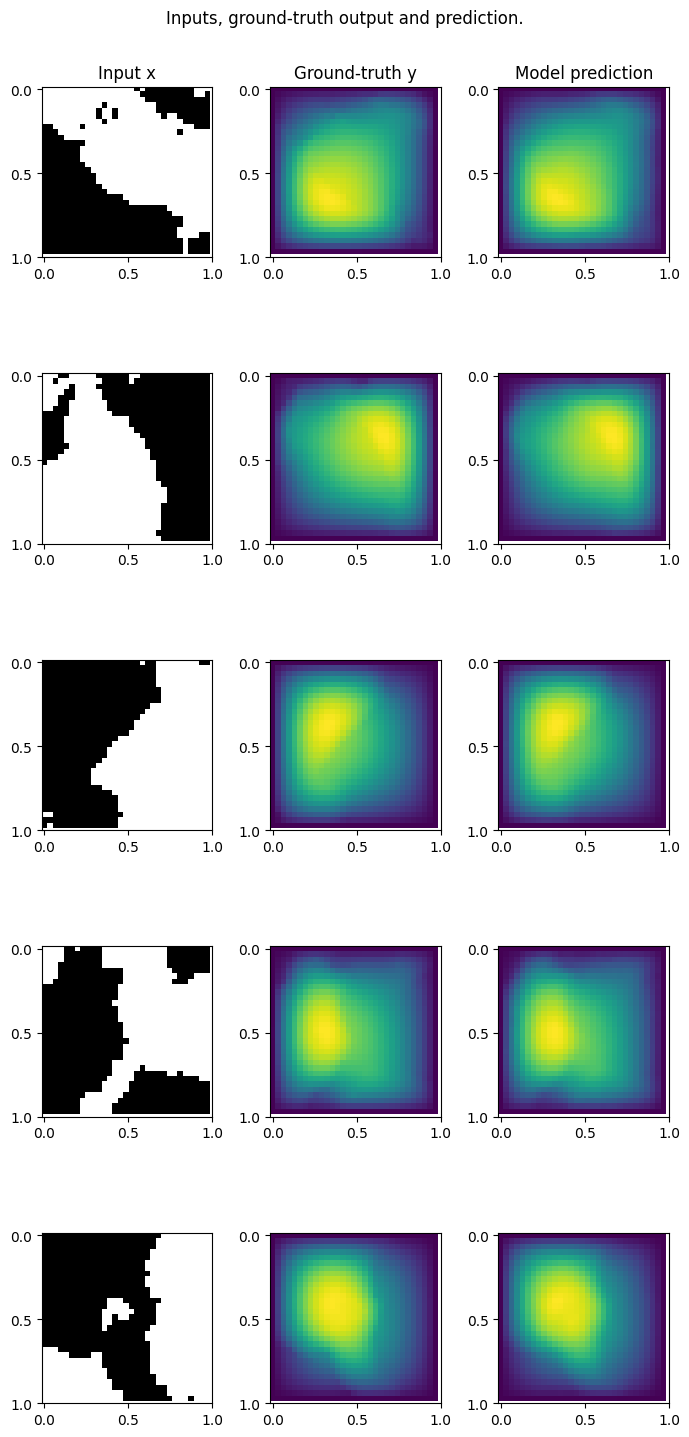

In [4]:
import matplotlib.pyplot as plt
h = 1/Np
n=5
model = torch.load('model/darcy_421_r14_ep300_ones_test')
fig = plt.figure(figsize=(7,3*n))

for index in range(n):
    x = x_test[index]
    x = x_normalizer.encode(x).to('cuda')
    y = y_test[index]
    # print(x.shape,y.shape)  #torch.Size([49, 49, 1]) torch.Size([49, 49])

    out = model(x.unsqueeze(0)).to('cpu')
    # print(out.shape)
    out = y_normalizer.decode(out)
    # out = out*(y_normalizer.std+eps)+y_normalizer.mean

    ax = fig.add_subplot(n, 3, index*3 + 1)
    x = x.to('cpu')
    im = ax.imshow(x[:,0].reshape(Np,Np).squeeze(), cmap='gray')
    # im = ax.imshow(x[:,1].reshape(Np,Np).squeeze())
    # # 添加颜色条
    # cbar = plt.colorbar(im, ax=ax)
    # cbar.set_label('Value')
    if index == 0: 
        ax.set_title('Input x')
    plt.xticks(np.linspace(0, Np, 3), np.linspace(0, 1, 3))
    plt.yticks(np.linspace(0, Np, 3), np.linspace(0, 1, 3))
    # plt.xticks([], [])
    # plt.yticks([], [])

    ax = fig.add_subplot(n, 3, index*3 + 2)
    ax.imshow(y.reshape(Np,Np).squeeze())
    if index == 0: 
        ax.set_title('Ground-truth y')
    plt.xticks(np.linspace(0, Np, 3), np.linspace(0, 1, 3))
    plt.yticks(np.linspace(0, Np, 3), np.linspace(0, 1, 3))
    # plt.xticks([], [])
    # plt.yticks([], [])

    ax = fig.add_subplot(n, 3, index*3 + 3)
    ax.imshow(out.squeeze().reshape(Np,Np).detach().numpy())
    if index == 0: 
        ax.set_title('Model prediction')
    plt.xticks(np.linspace(0, Np, 3), np.linspace(0, 1, 3))
    plt.yticks(np.linspace(0, Np, 3), np.linspace(0, 1, 3))
    # plt.xticks([], [])
    # plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
fig.show()

# 中间层图像

5
torch.Size([1, 961, 4])


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument tensors in method wrapper_CUDA_cat)

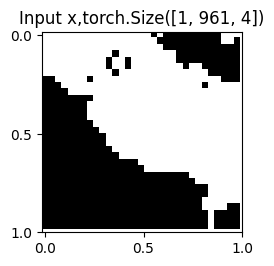

In [6]:
import matplotlib.pyplot as plt
h = 1/Np
model = torch.load('model/darcy_421_r14_ep300')

n=4
length = len(model.ws)
m = length+1
print(m)
fig = plt.figure(figsize=(15,m*n))
for index in range(n):

    x = x_test[index]
    x = x_normalizer.encode(x).to('cuda')

    x = x.unsqueeze(0)
    ax = fig.add_subplot(n, m, index*m + 1)
    print(x.shape)
    x0 = x[0,:,0].reshape(Np,Np).to("cpu")
    im = ax.imshow(x0.detach().numpy(), cmap='gray')
    if index == 0: 
        ax.set_title('Input x,{}'.format(x.shape))
    plt.xticks(np.linspace(0, Np, 3), np.linspace(0, 1, 3))
    plt.yticks(np.linspace(0, Np, 3), np.linspace(0, 1, 3))



    
    x = model.fc0(x)
    x = x.permute(0, 2, 1)


    for i, (layer, w) in enumerate(zip(model.sp_layers, model.ws)):
        x1 = layer(x)
        x2 = w(x)
        res = x1 + x2
        if model.act is not None and i != length - 1:
            res = model.act(res)
        if model.residual[i] == True:
            x = x + res
        else:
            x = res
        if i != length-1:
            x0 = x[0,0,:].reshape(Np,Np).to("cpu")
            ax = fig.add_subplot(n, m, index*m + i+2)
            im = ax.imshow(x0.detach().numpy())
            if index == 0: 
                ax.set_title('x{},{}'.format(i+1,x.shape))
            plt.xticks(np.linspace(0, Np, 3), np.linspace(0, 1, 3))
            plt.yticks(np.linspace(0, Np, 3), np.linspace(0, 1, 3))
    
    
    x = x.permute(0, 2, 1)

    # if fc_dim = 0, we do not have nonlinear layer
    fc_dim = model.fc_dim

    if fc_dim > 0:
        x = model.fc1(x)
        if model.act is not None:
            x = model.act(x)

    out = model.fc2(x)
    out = y_normalizer.decode(out)
    out = out.reshape(Np,Np).to("cpu")

    ax = fig.add_subplot(n, m, index*m + m)
    im = ax.imshow(out.squeeze().detach().numpy())

    if index == 0: 
        ax.set_title('out,{}'.format(out.shape))
    plt.xticks(np.linspace(0, Np, 3), np.linspace(0, 1, 3))
    plt.yticks(np.linspace(0, Np, 3), np.linspace(0, 1, 3))



fig.suptitle('x,x1,x2,x3,y', y=0.98)
plt.tight_layout()
fig.show()

# 分量大小

C:\Users\15461\AppData\Local\Temp\ipykernel_17160\27381161.py:124: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


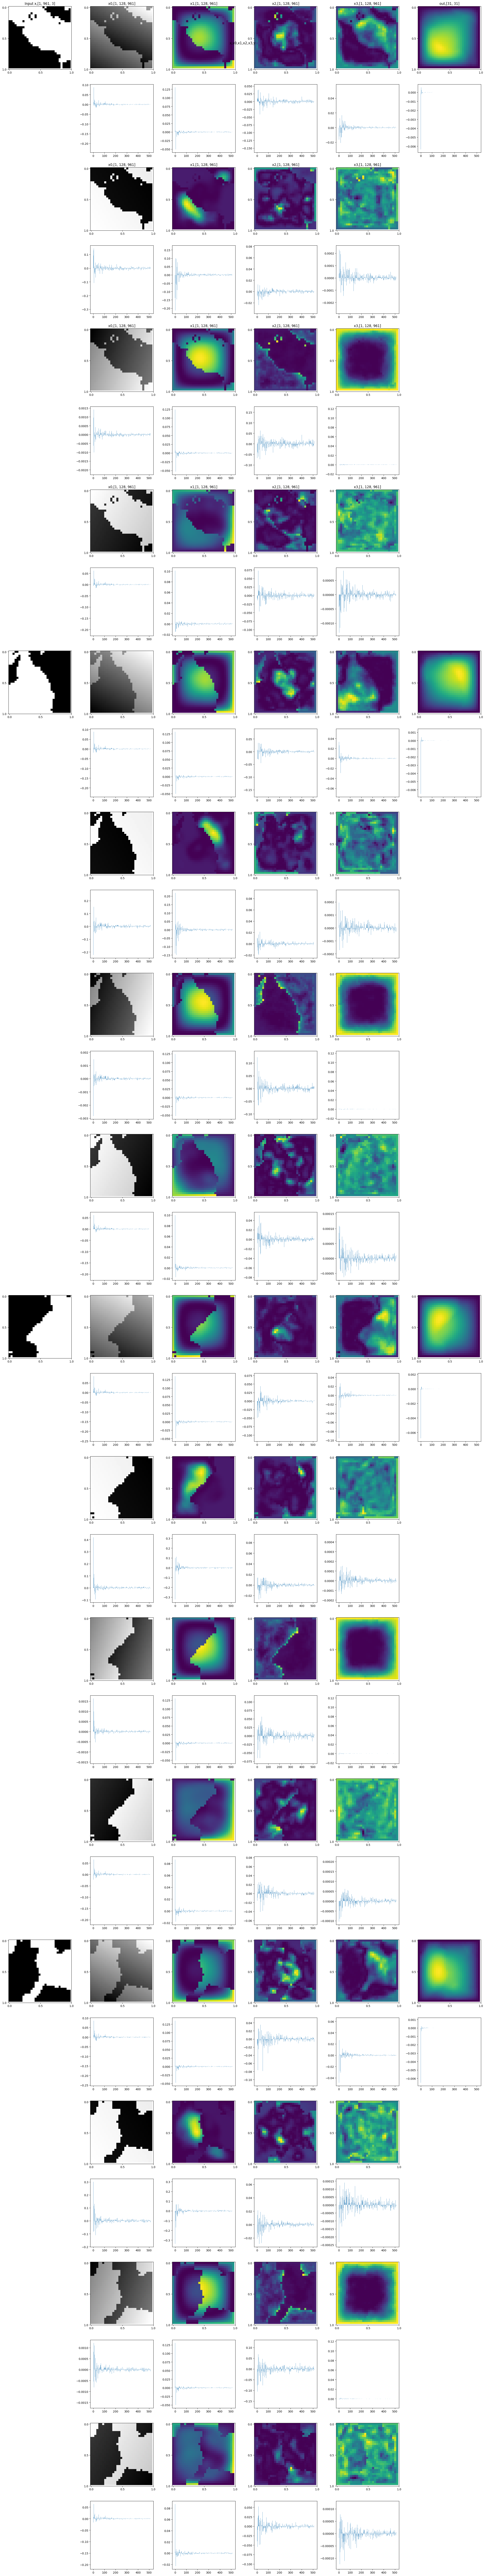

In [42]:
import matplotlib.pyplot as plt
h = 1/Np
model = torch.load('model/darcy_421_r14_ep300')

n = 4 
l = 4 #l表示中间层要画出的channel个数
length = len(model.ws)
m = length+2

fig = plt.figure(figsize=(4*m,8*l*n))  #宽度、高度
wbases = wbases_pca
with torch.no_grad():
    for index in range(n):

        x = x_test[index]
        y = y_test[index]
        x = x_normalizer.encode(x).to('cuda')

        x = x.unsqueeze(0)
        j = 1
        ax = fig.add_subplot(n*2*l, m, index*m*2*l + j)
        j = j+1
        x0 = x[0,:,0].reshape(Np,Np).to("cpu")
        im = ax.imshow(x0.detach().numpy(), cmap='gray')
        if index == 0: 
            ax.set_title('Input x,{}'.format(list(x.shape)))
        plt.xticks(np.linspace(0, Np, 3), np.linspace(0, 1, 3))
        plt.yticks(np.linspace(0, Np, 3), np.linspace(0, 1, 3))

        

        
        x = model.fc0(x)
        x = x.permute(0, 2, 1)

        for k in range(l):
            ax = fig.add_subplot(n*2*l, m, index*m*2*l+ 2*k*m + j)
            x0 = x[0,k,:].reshape(Np,Np).to("cpu")
            im = ax.imshow(x0.detach().numpy(), cmap='gray')
            if index == 0   and k==0 : 
                ax.set_title('x0,{}'.format(list(x.shape)))
            plt.xticks(np.linspace(0, Np, 3), np.linspace(0, 1, 3))
            plt.yticks(np.linspace(0, Np, 3), np.linspace(0, 1, 3))


            ax = fig.add_subplot(n*2*l, m, index*m*2*l+(2*k+1)*m + j)
            x_hat = torch.einsum("bcx,xk->bck", x, wbases)
            # print("x_hat.shape",x_hat.shape)
            x_hat0 = x_hat[0,k,:].to('cpu')
            x_range = range(len(x_hat0))
            ax.bar(x_range, x_hat0,align='center', alpha=0.7)
            # ax.set_ylim(min(x_hat0) * 1.2, max(x_hat0) * 1.2)
            # plt.ylim(-1, 1)
        j = j+1
        


        for i, (layer, w) in enumerate(zip(model.sp_layers, model.ws)):
            x1 = layer(x)
            x2 = w(x)
            res = x1 + x2
            if model.act is not None and i != length - 1:
                res = model.act(res)
            if model.residual[i] == True:
                x = x + res
            else:
                x = res
            if i != length-1:
                for k in range(l):
                    x0 = x[0,k,:].reshape(Np,Np).to("cpu")
                    ax = fig.add_subplot(n*2*l, m, index*m*2*l +2*k*m+ j)
                    im = ax.imshow(x0.detach().numpy())
                    if index == 0  and k==0: 
                        ax.set_title('x{},{}'.format(i+1,list(x.shape)))
                    plt.xticks(np.linspace(0, Np, 3), np.linspace(0, 1, 3))
                    plt.yticks(np.linspace(0, Np, 3), np.linspace(0, 1, 3))

                    ax = fig.add_subplot(n*2*l, m, index*m*2*l+(2*k+1)*m + j)
                    x_hat = torch.einsum("bcx,xk->bck", x, wbases)
                    # print("x_hat.shape",x_hat.shape)
                    x_hat0 = x_hat[0,k,:].to('cpu')
                    x_hat0 = list(x_hat0)
                    x_range = range(len(x_hat0))
                    ax.bar(x_range, x_hat0,align='center', alpha=0.7)
                    # ax.set_ylim(min(x_hat0) * 1.2, max(x_hat0) * 1.2)
                    # plt.ylim(min(x_hat0) * 1.2, max(x_hat0) * 1.2)
                j = j+1
        
        
        x = x.permute(0, 2, 1)

        # if fc_dim = 0, we do not have nonlinear layer
        fc_dim = model.fc_dim

        if fc_dim > 0:
            x = model.fc1(x)
            if model.act is not None:
                x = model.act(x)

        out = model.fc2(x)
        out = y_normalizer.decode(out)
        out = out.reshape(Np,Np).to("cpu")
        # print(m,j)

        ax = fig.add_subplot(n*2*l, m, index*m*2*l + j)
        im = ax.imshow(out.squeeze().detach().numpy())
        if index == 0: 
            ax.set_title('out,{}'.format(list(out.shape)))
        plt.xticks(np.linspace(0, Np, 3), np.linspace(0, 1, 3))
        plt.yticks(np.linspace(0, Np, 3), np.linspace(0, 1, 3))
        ax = fig.add_subplot(n*2*l, m, index*m*2*l+m + j)
        x_hat = torch.einsum("bcx,xk->bck", out.reshape(1,1,Np*Np).to('cuda'), wbases)
        # print("x_hat.shape",x_hat.shape)
        x_hat0 = x_hat[0,0,:].to('cpu')
        x_range = range(len(x_hat0))
        ax.bar(x_range, x_hat0,align='center', alpha=0.7)
        # ax.set_ylim(min(x_hat0) * 1.2, max(x_hat0) * 1.2)
        # plt.ylim(-1, 1)

        

fig.suptitle('x,x0,x1,x2,x3,y', y=0.98)
plt.tight_layout()
fig.show()